In [11]:
devtools::install_github("clairbarnes/rwwa")
suppressMessages(library(rwwa))


── R CMD build ─────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/RtmpndXuwH/remotes298d0aa56e3/clairbarnes-rwwa-2ca8168/DESCRIPTION’
─  preparing ‘rwwa’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘rwwa_0.1.1.tar.gz’
   


# Get 6-month Nino time series

In [2]:
nino <- read.csv("ts/nino34_det.csv", col.names = c("time", "nino"))
nino$nino_6m <- filter(nino$nino, rep(1/6,6), sides = 1)
nino$year <- substr(nino$time,1,4)

nino_6m <- nino[substr(nino$time,6,7) == "11",c("year", "nino_6m")]
write.csv(nino_6m, "ts/nino_6monthly.csv", row.names = F)

# Time series

In [3]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))

# load time series of interest
ts <- read.csv("ts/cx_spei6_ms.csv")

# combine into single dataframe
df <- merge(merge(gmst, nino), ts)

df$nino_pos <- df$nino
df$nino_pos[df$nino <= 0] <- 0

spei_2023 <- df$spei[df$year == 2023]

cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0,0),
                "2000" = cov_2023 - c(0.5,0,0),
                "neut" = c(0,0,0))

In [42]:
png("fig/timeseries.png", height = 480, width = 720); {
    plot(df$year-0.5, df$spei, type = "s", lwd = 2, ylim = c(-3,3))

    points(df[df$year == 2023,c("year", "spei")], col = "magenta", lwd = 3)
    abline(h = 0, lty = 2)
    lines(df$year, fitted(loess(spei ~ year, df)), col = "forestgreen", lty = "22", lwd = 3)
    # lines(df$year, df$gmst, lwd = 3, col = "red3")
    # lines(df$year, df$nino, lwd = 2, col = "blue")
    
    # legend("bottomleft", c("SPEI", "GMST", "Nino3.4"), lty = 1, lwd = 2, col = c("black", "red3", "blue"))
}; dev.off()

png 
  2

# Fitted trend vs time

In [25]:
mdl_gmst <- fit_ns("norm", "shift", df, "spei", c("gmst"), lower = T)
mdl_nino <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino"), lower = T)
mdl <- mdl_ninopos <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino_pos"), lower = T)

models <- list("GMST only" = mdl_gmst, "Nino3.4" = mdl_nino, "El Nino" = mdl_ninopos)

In [7]:
rbind("aic" = sapply(models, aic), sapply(models, rsquared))

,GMST only,Nino3.4,El Nino
aic,129.65735180,128.3698368,121.7028101
r2,0.09776828,0.1613315,0.2768191
r2.adj,0.07678615,0.1213949,0.2423820


In [8]:
png("fig/trend-vs-time.png", height = 480, width = 720); {
    plot_trend(mdl_ninopos, ylim = c(-3,3), add_loess = T, rp = c(25))
    abline(h = 0, lty = 2)
}; dev.off()

png 
  2

# Fitted trend vs covariates

In [26]:
png("fig/trend-vs-gmst.png", height = 480, width = 720); {
    plot_covtrend(mdl, "gmst", ylim = c(-3,3), rp = c(5,25), add_loess = T)
    abline(h = 0, lty = 2)
}; dev.off()

In [27]:
png("fig/trend-vs-nino.png", height = 480, width = 720); {
    plot_covtrend(mdl_ninopos, "nino", ylim = c(-3,3), add_loess = T, rp = c(5,25),
              trend_cov = data.frame(sapply(mdl_ninopos$covnm, function(cnm) if(cnm == "nino_pos") {mdl_ninopos$data[,cnm]} else {mean(mdl_ninopos$data[,cnm])}, simplify = F)))
    abline(h = 0, lty = 2)
}; dev.off()

png 
  2

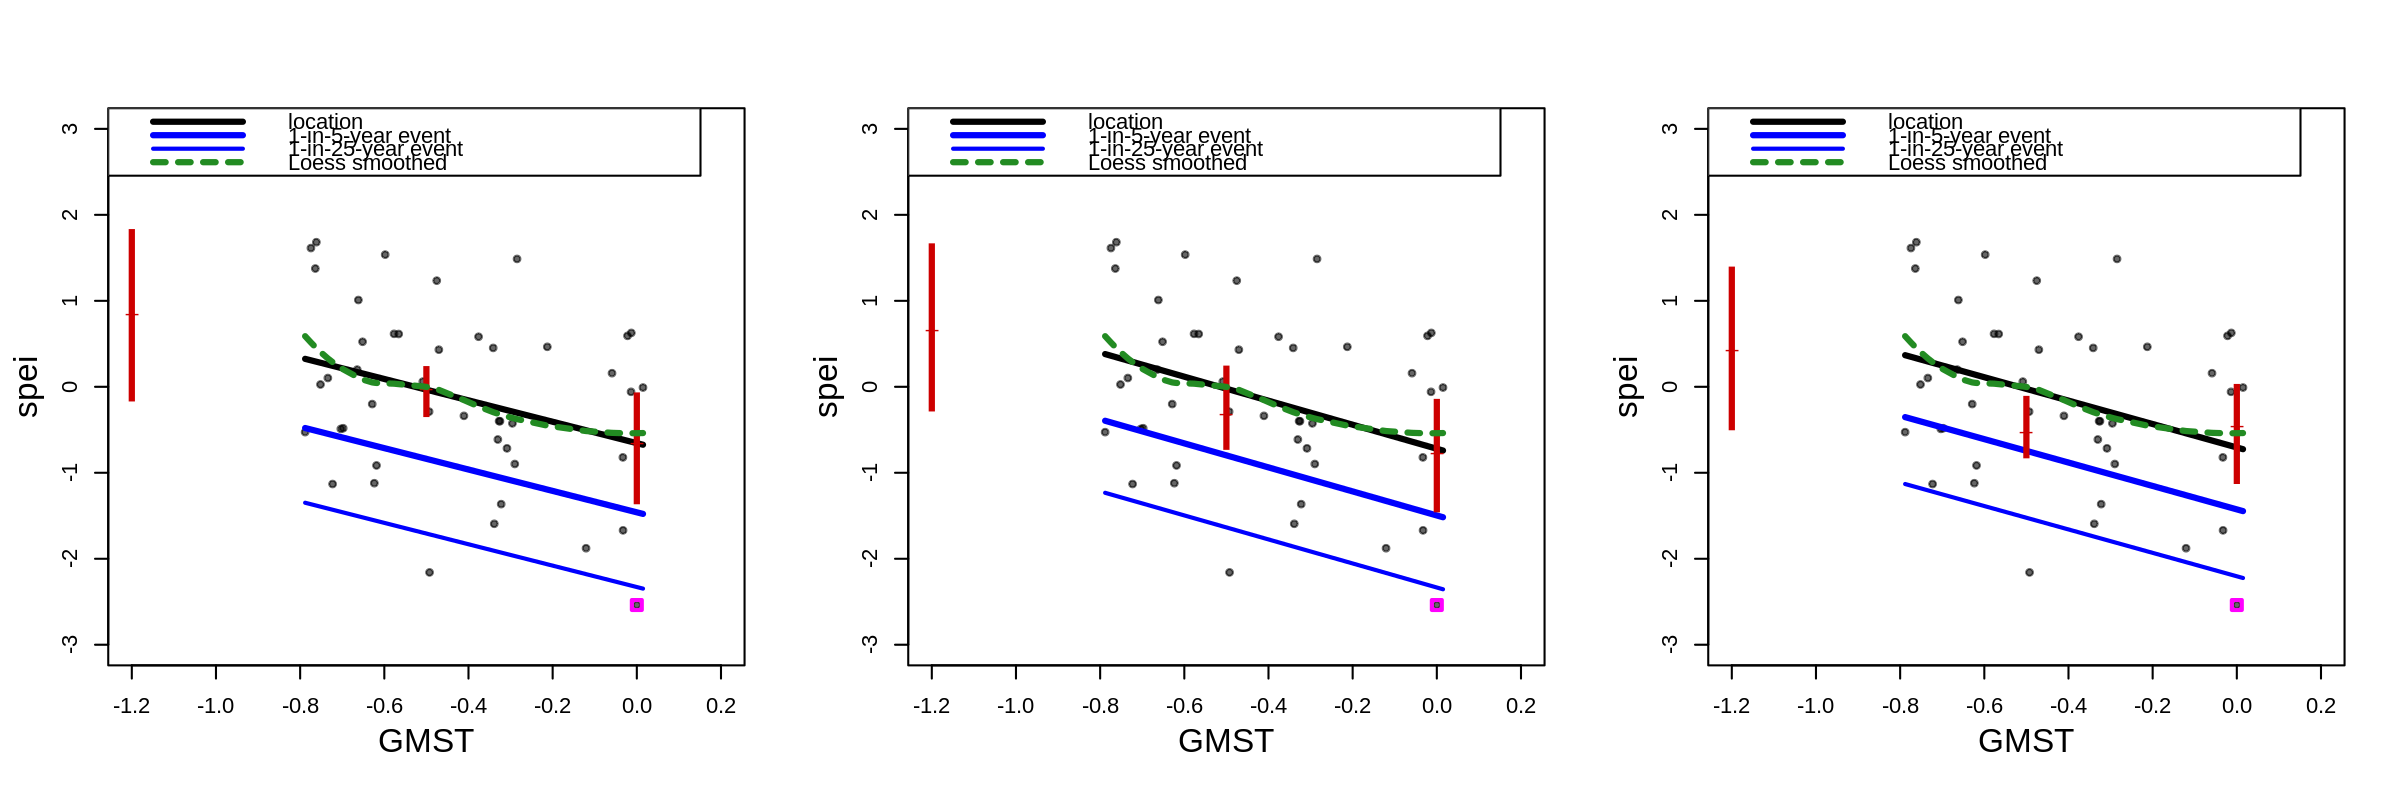

In [47]:
prep_window(c(1,3))
plot_covtrend(mdl_gmst, "gmst", ylim = c(-3,3), rp = c(5,25), add_loess = T, ci_cov = cov_cf)
plot_covtrend(mdl_nino, "gmst", ylim = c(-3,3), rp = c(5,25), add_loess = T, ci_cov = cov_cf)
plot_covtrend(mdl_ninopos, "gmst", ylim = c(-3,3), rp = c(5,25), add_loess = T, ci_cov = cov_cf)

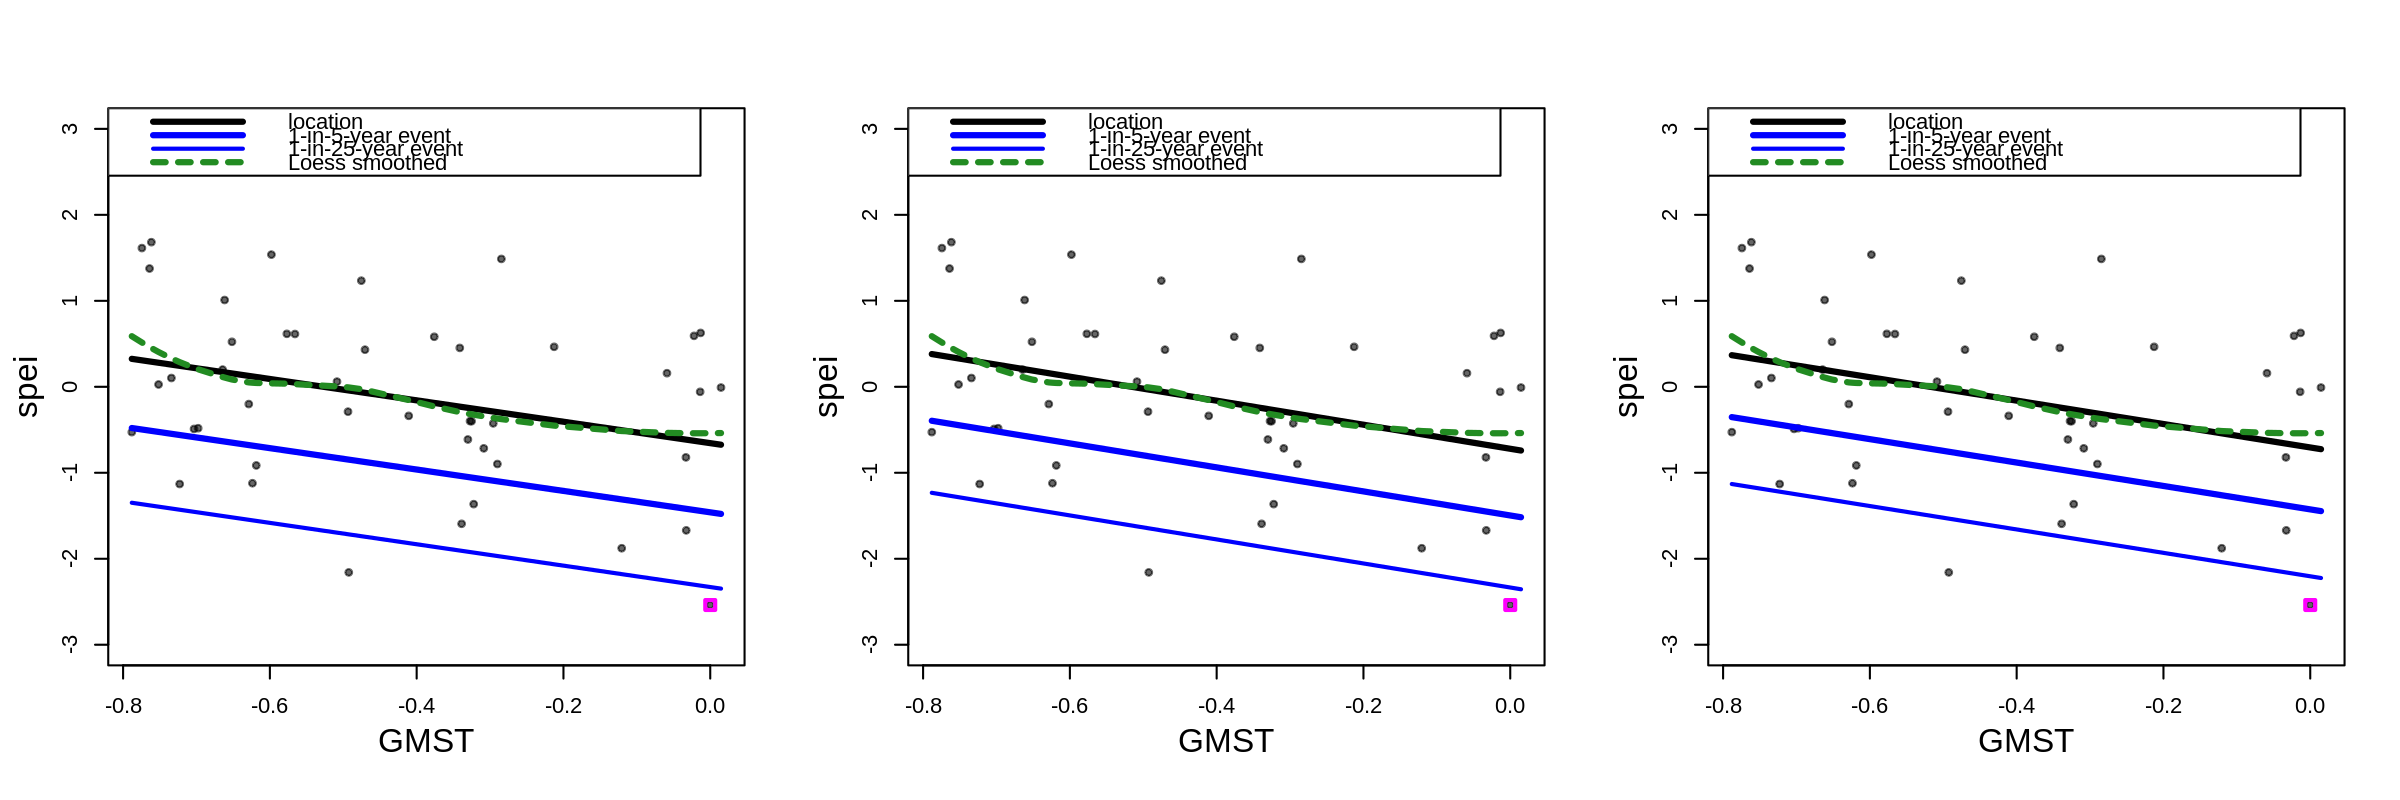

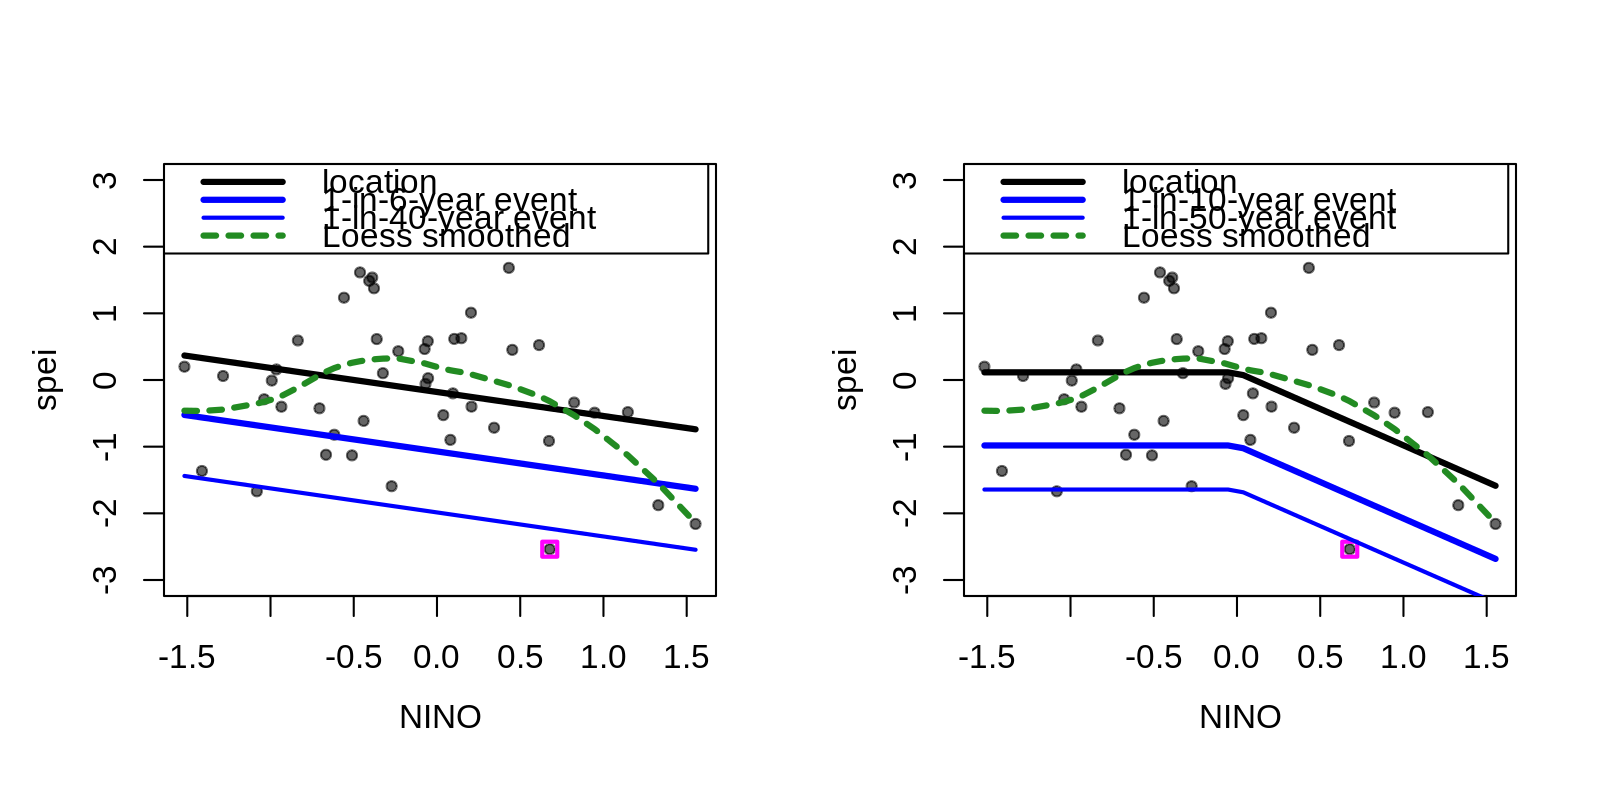

In [19]:
prep_window(c(1,2))

df_nino <- df[order(df$nino),]
df_nino$gmst <- mean(df_nino$gmst)

plot_covtrend(mdl_nino, "nino", ylim = c(-3,3), add_loess = T)

plot_covtrend(mdl_ninopos, "nino", ylim = c(-3,3), add_loess = T, rp = c(10,50),
              trend_cov = data.frame(sapply(mdl_ninopos$covnm, function(cnm) if(cnm == "nino_pos") {mdl_ninopos$data[,cnm]} else {mean(mdl_ninopos$data[,cnm])}, simplify = F)))

In [22]:
sapply(models, function(mdl) c("now" = return_period(mdl, spei_2023, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) return_period(mdl, spei_2023, fixed_cov = cov_cf[rnm,,drop = F]))))

,GMST only,Nino3.4,El Nino
now,40.87801,20.11517,16.66316
hist,4824.73488,3800.63062,3753.13974
2000,227.33912,123.91083,106.55639
neut,40.87801,35.84598,129.41116


# Return level plots

In [141]:
prep_window(c(1,2))

png("fig/return-levels_gmst.png"); {
    plot_returnlevels(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop = F], nsamp = 1000, model_desc = F)
}; dev.off()

png("fig/return-levels_nino.png"); {
    plot_returnlevels(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], nsamp = 1000, model_desc = F)
    
}; dev.off()

png 
  2

png 
  2

---
# Joint distribution of PET, PR & SPEI

In [12]:
library(copula)

# compute joint exceedances over regular grid for easy plotting
copula_mesh <- function(mdl_x, mdl_y, copula, cov1, xrange, yrange, n = 32) {
    
    # compute joint exceedances over regular grid for easy plotting
    
    if(missing(xrange)) xrange <- range(pretty(mdl_x$x))
    if(missing(yrange)) yrange <- range(pretty(mdl_y$x))
    
    # define the regular mesh for plotting
    x_mesh <- seq(xrange[1], xrange[2],length.out = n)
    y_mesh <- seq(yrange[1], yrange[2], length.out = n)
    
    # convert the regular mesh to U space
    x_umesh <- map_to_u(mdl_x, x_mesh, fixed_cov = cov1)
    y_umesh <- map_to_u(mdl_y, y_mesh, fixed_cov = cov1)
    
    if(substr(mdl_x$varnm,1,5) == "log10") { x_mesh <- 10^x_mesh }
    if(substr(mdl_y$varnm,1,5) == "log10") { y_mesh <- 10^y_mesh }
    
    return(list("x" = x_mesh, "y" = y_mesh, "z" = sapply(y_umesh, function(y) sapply(x_umesh, function(x) pCopula(cbind(x,y), copula)))))
}

In [13]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))
nino$nino_pos <- nino$nino
nino$nino_pos[nino$nino <= 0] <- 0

# load time series of interest
pet <- read.csv("ts/cx_pet6_ms.csv")
pr <- read.csv("ts/cx_pr6_ms.csv", col.names = c("year", "pr"))

# compile into single dataframe
df <- merge(merge(merge(gmst, nino), pet), pr)

# covariates to define scenarios
cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]

cov_cf <- rbind("histnino" = cov_2023 - c(1.2,0,0),
                "2023neut" = c(0,0,0),
                "histneut" = c(-1.2,0,0))

## Check marginals: pet, pr ~ gmst + nino

In [14]:
# fit marginal distributions

models_pet <- sapply(list("GMST only" = "gmst", "GMST + ENSO" = c("gmst", "nino"), "GMST + Nino" = c("gmst", "nino_pos")), function(covariates) {
    fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = covariates, lower = F)
}, simplify = F)

models_pr <- sapply(list("GMST only" = "gmst", "GMST + ENSO" = c("gmst", "nino"), "GMST + Nino" = c("gmst", "nino_pos")), function(covariates) {
    fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = covariates, lower = T)
}, simplify = F)

In [15]:
print("PET:")
rbind("aic" = sapply(models_pet, aic), sapply(models_pet, rsquared))

[1] "PET:"


,GMST only,GMST + ENSO,GMST + Nino
aic,373.1025583,374.8751532,371.8046204
r2,0.6778241,0.6794481,0.7005911
r2.adj,0.6703316,0.6641837,0.6863335


In [16]:
print("Precip:")
rbind("aic" = sapply(models_pr, aic), sapply(models_pr, rsquared))

[1] "Precip:"


,GMST only,GMST + ENSO,GMST + Nino
aic,501.596007591,497.85810025,489.2972876
r2,0.001912996,0.13216271,0.2777579
r2.adj,-0.021298330,0.09083713,0.2433654


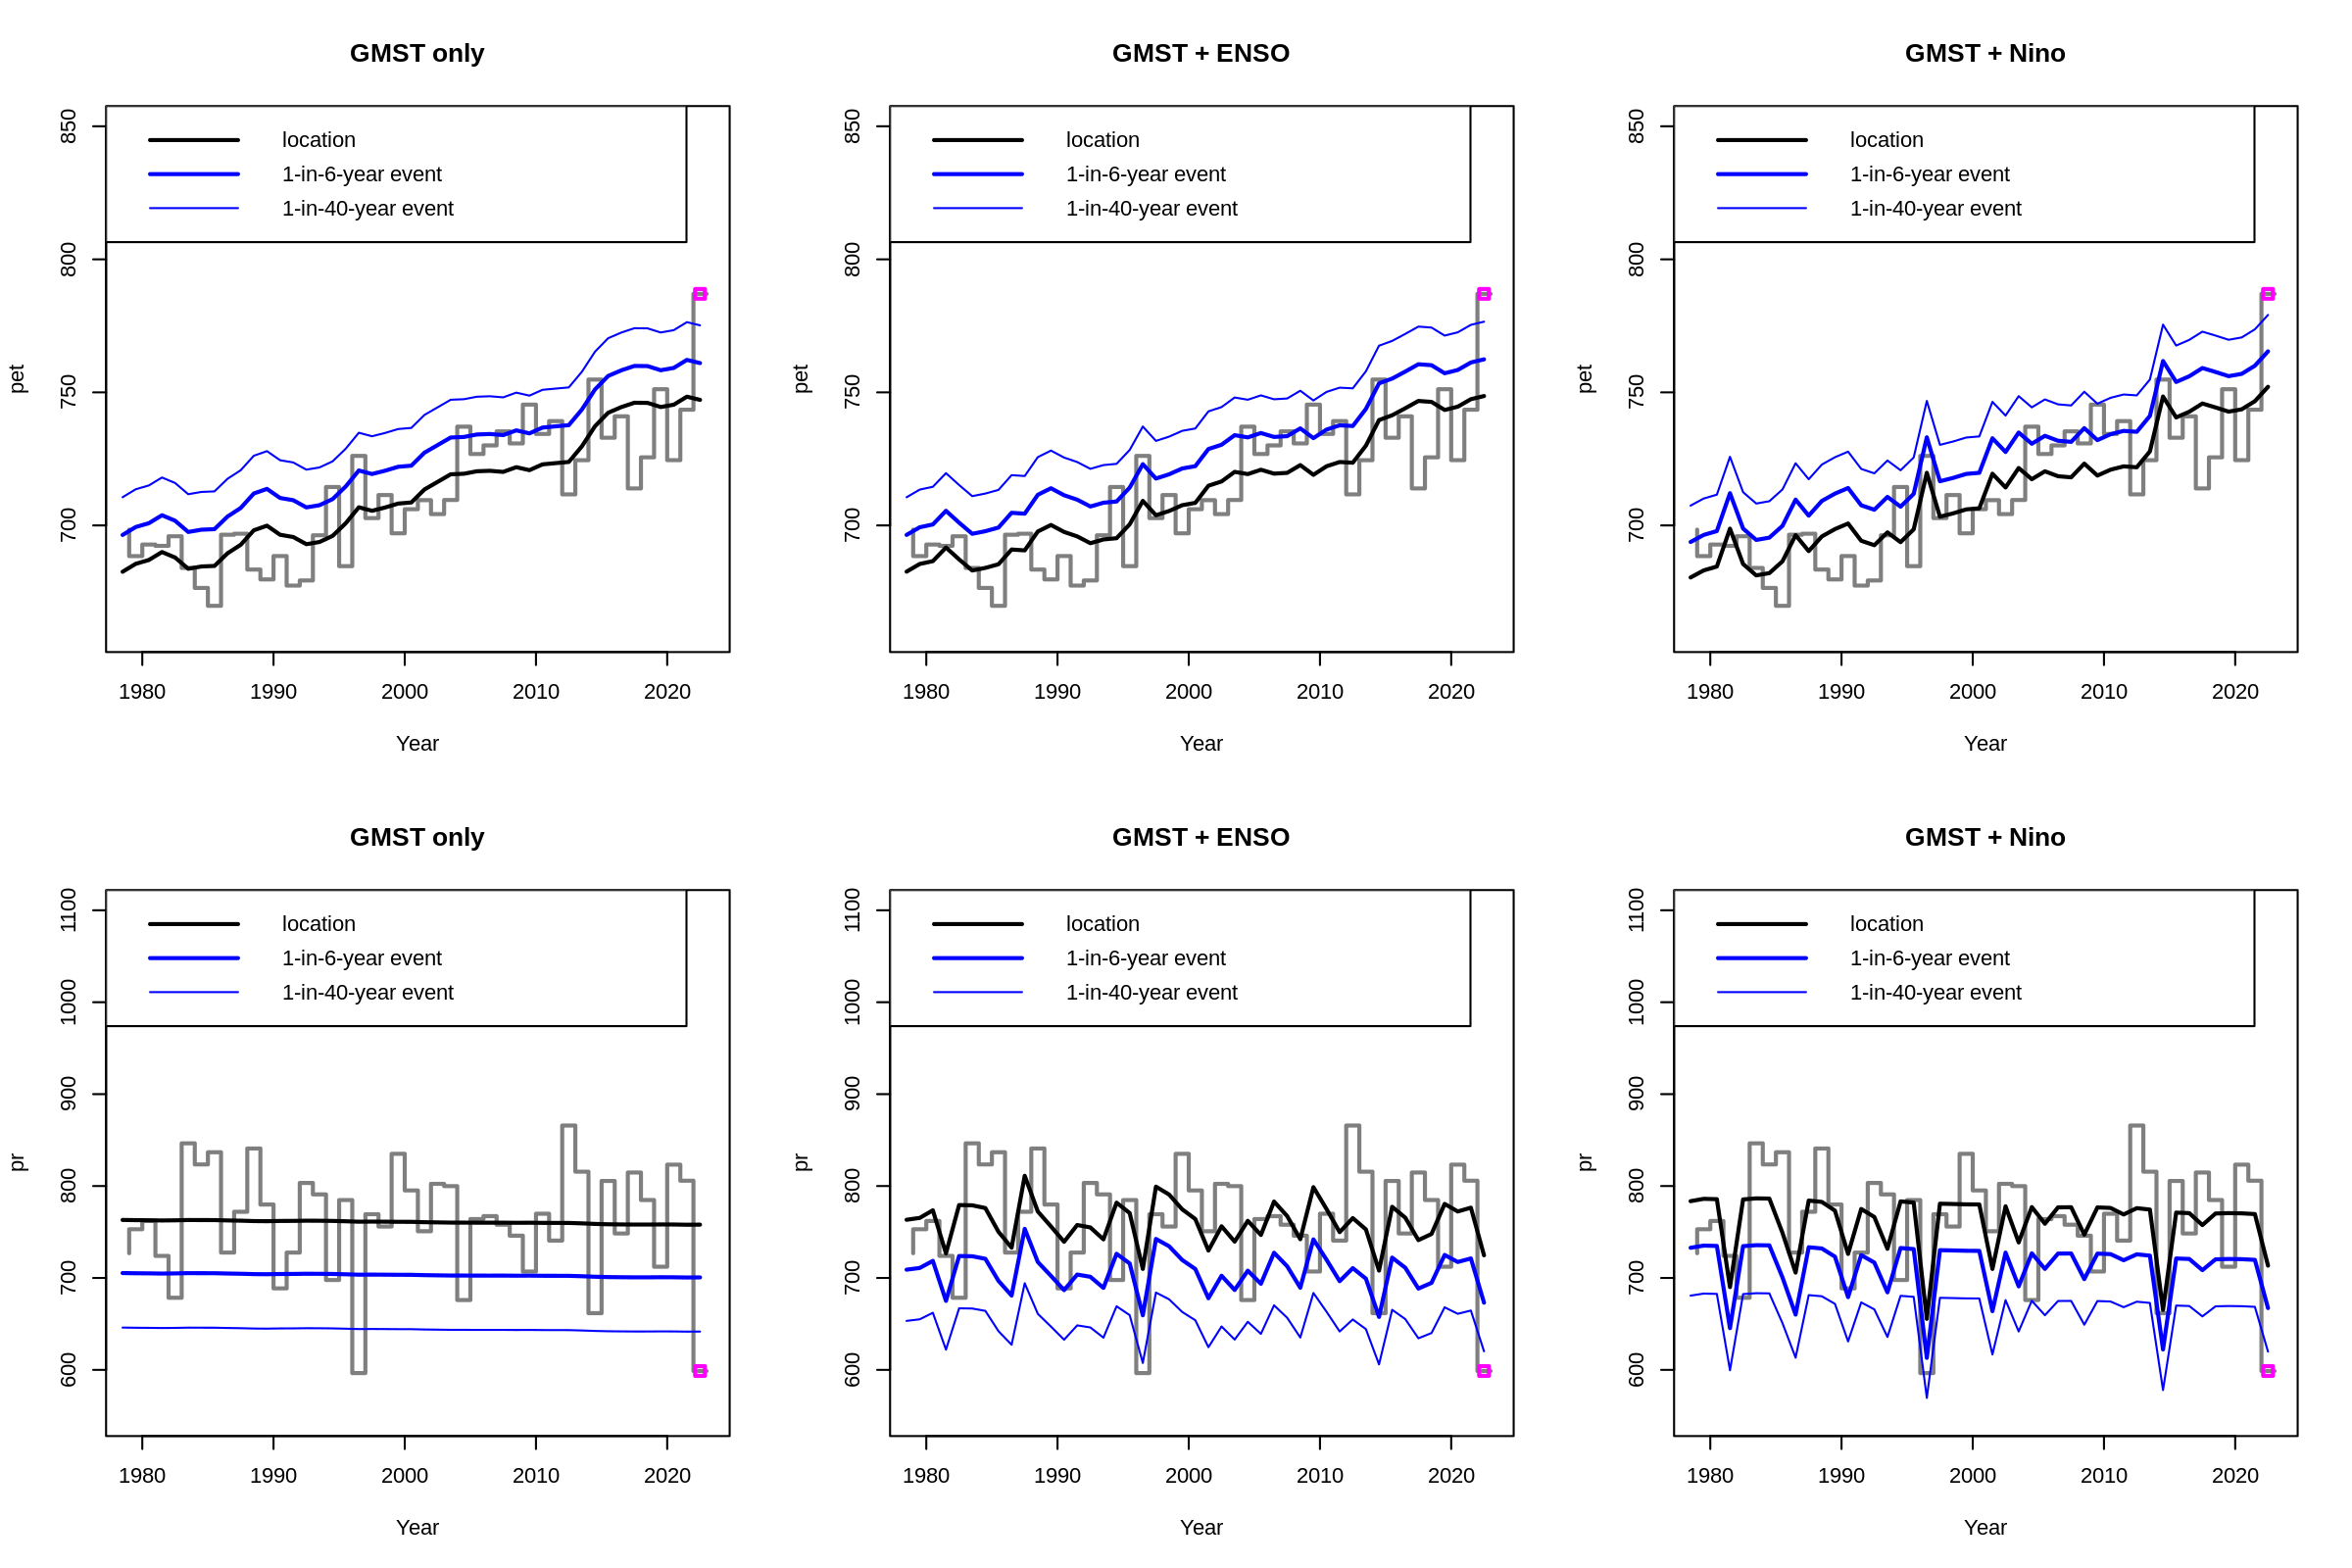

In [17]:
prep_window(c(2,3))

for(mnm in names(models_pet)) plot_trend(models_pet[[mnm]], main = mnm, ylim = c(660,850))
for(mnm in names(models_pr)) plot_trend(models_pr[[mnm]], main = mnm, ylim = c(550,1100))


### Check copula fit

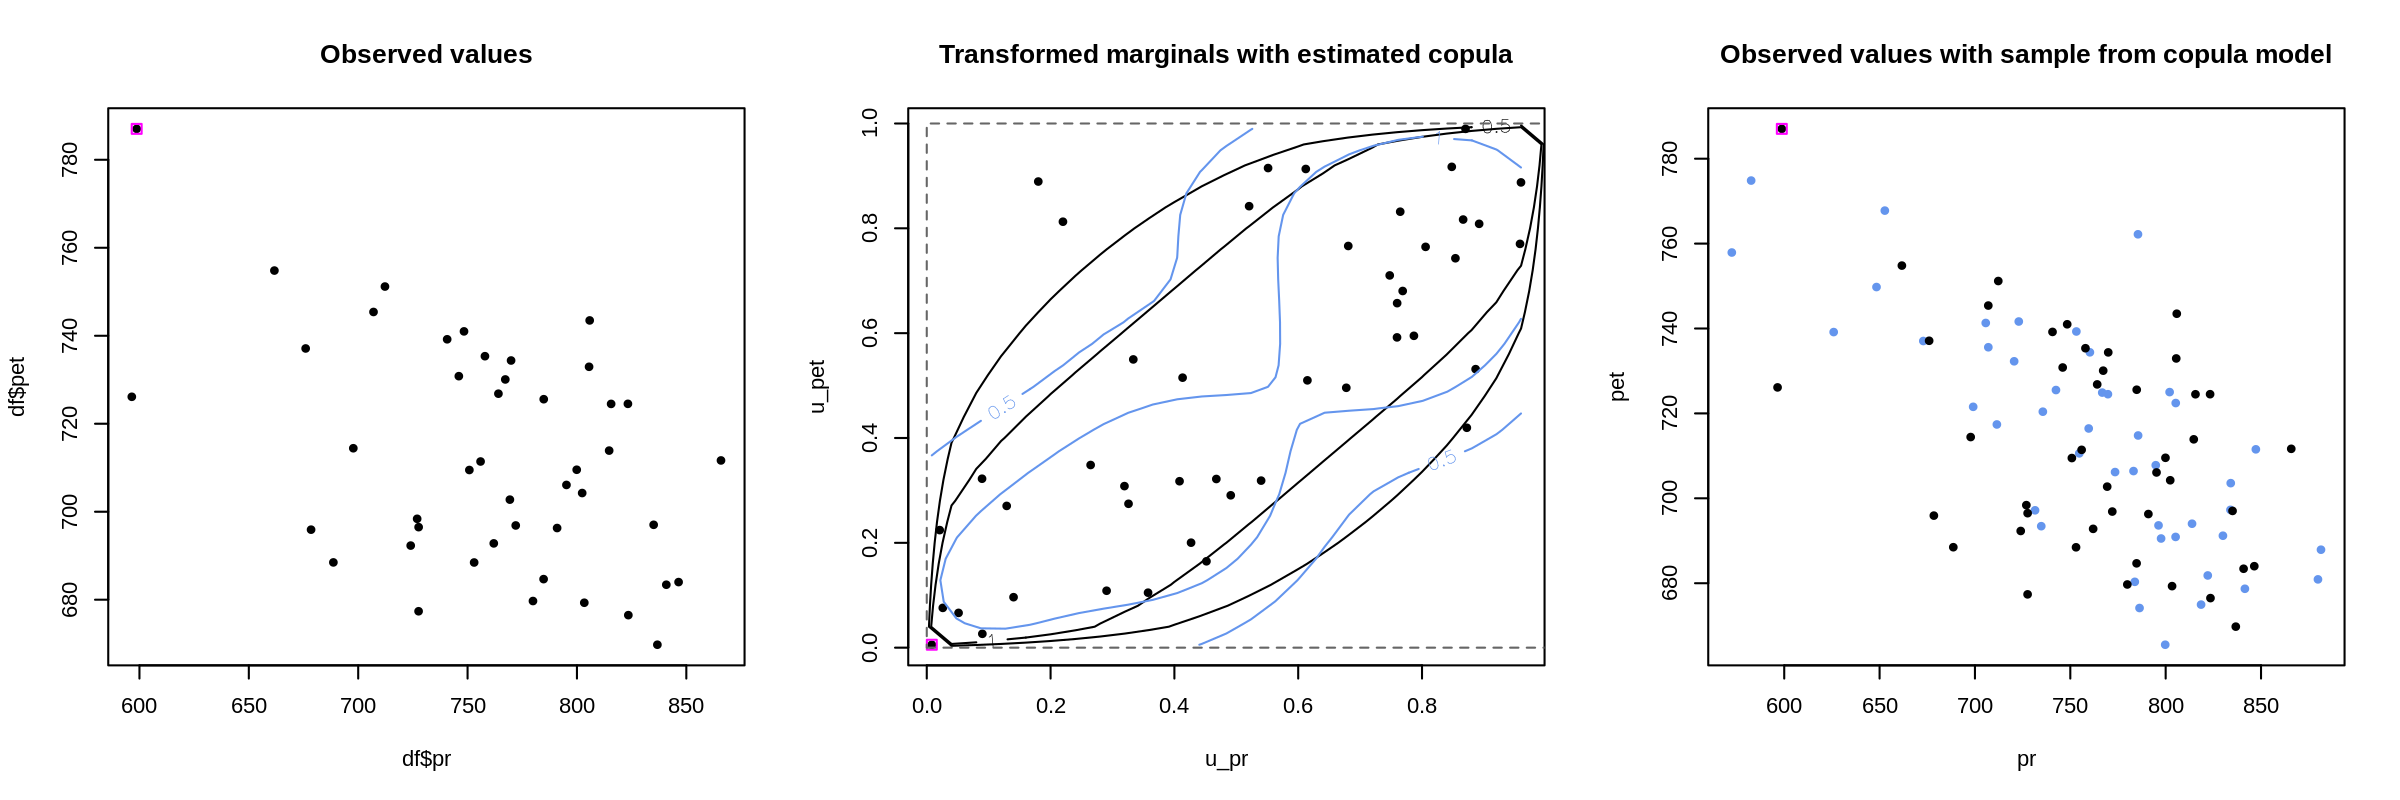

In [20]:
# fit marginal distributions
mdl_pet <- fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = c("gmst", "nino_pos"), lower = F)
mdl_pr <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = c("gmst", "nino_pos"), lower = T)  

# transform marginals to U
u_pr <- map_to_u(mdl_pr)
u_pet <- map_to_u(mdl_pet)

fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_pet), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting

prep_window(c(1,3))

plot(df$pr, df$pet, main = "Observed values")
points(df[df$year == 2023,c("pr","pet")], col = "magenta", pch = 0)

# check fit of copula against 2d KDE
plot(u_pr, u_pet, main = "Transformed marginals with estimated copula")
points(u_pr[df$year == 2023], u_pet[df$year == 2023], col = "magenta", pch = 0)

cop <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))
contour(cop, dCopula, add = T, levels = c(0.5,1))
contour(MASS::kde2d(u_pr, u_pet), col = "cornflowerblue", add = T, levels = c(0.5,1))

# generate a sample from the fitted copula to check relationship with actual values
# MVDC needs copula fitted without accounting for lower/upper tails, since it also uses the actual marginals - adjust correlation accordingly
fitted_mvdc <- mvdc(copula = tCopula(-coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0)), 
                    margins=c("norm", "norm"), paramMargins=list(list(mean=mean(df$pr), sd=sd(df$pr)), list(mean=mean(df$pet), sd=sd(df$pet))))

set.seed(42)
mvsamp <- rMvdc(nrow(df), fitted_mvdc)

plot(mvsamp, col = "cornflowerblue", xlim = range(mvsamp[,1], df$pr), ylim = range(mvsamp[,2], df$pet), xlab = "pr", ylab = "pet",
     main = "Observed values with sample from copula model")
points(df$pr, df$pet, pch = 20, col = "black")
points(df[df$year == 2023,c("pr","pet")], col = "magenta", pch = 0)

### **Fit chosen model & get contour values**

In [21]:
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))

In [22]:
# get expected return levels in factual & counterfactual climates
rp_pr <- return_period(mdl_pr)[nrow(df)]
rl_pr <- as.list(c("2023" = eff_return_level(mdl_pr, rp_pr, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) eff_return_level(mdl_pr, rp_pr, fixed_cov = cov_cf[rnm,,drop = F]))))

rp_pet <- return_period(mdl_pet)[nrow(df)]
rl_pet <- as.list(c("2023" = eff_return_level(mdl_pet, rp_pet, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) eff_return_level(mdl_pet, rp_pet, fixed_cov = cov_cf[rnm,,drop = F]))))

In [23]:
# joint return periods
joint_rp <- as.list(c("2023" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_2023), map_to_u(mdl_pet, mdl_pet$ev, cov_2023)), cfit),
  sapply(rownames(cov_cf), function(rnm) 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_cf[rnm,,drop = F]), map_to_u(mdl_pet, mdl_pet$ev, cov_cf[rnm,,drop = F])), cfit))))
joint_rp

$`2023`
[1] 462.4431

$histnino
[1] -4.793054e+16

$`2023neut`
[1] 5475.559

$histneut
[1] 2.809197e+17

In [24]:
# double- check using PI marginals & ERLs - should give the same joint return period as today's event in today's climate
1/pCopula(c(map_to_u(mdl_pr, rl_pr$histnino, cov_cf["histnino",,drop = F]), map_to_u(mdl_pet, rl_pet$histnino, cov_cf["histnino",,drop = F])), cfit)

[1] 462.4431

In [25]:
cmesh_2023 <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_2023, xrange = c(550,900), yrange = c(550,800), n = 64)
cmesh_hist <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_cf["histnino",,drop = F], xrange = c(550,900), yrange = c(550,700))

## Compute gridded SPEI for filled contours

In [27]:
library("SPEI")

In [230]:
# create time series of effective precip
eff_pr <- ts((df$pr - df$pet)[(df$year >= 1990) & (df$year <= 2020)], start = 1990, frequency = 1)
fitted_spei <- spei(eff_pr, scale = 1, verbose = F)

# get intercept of SPEI - can use this to draw polygons for the successive drought categories
spei_0 <- sapply(0:850, function(pe) spei(ts(550 - pe), scale = 1, params = coef(fitted_spei), verbose = F)$fitted)
spei_int <- function(x) which.min(abs(spei_0 - x)) - 550

### **Contour plot**

In [232]:
# check that plot region covers all contours & features of interest
prep_window(c(1,1), lwd = 2)

pt.cex = 1.25

pr_x = seq(550,900,5)
pet_y = seq(550,800,5)

pdf("fig/decomposition.pdf"); par(lwd = 2, mar = c(3.5,3.5,2.5,1)); {
    
    matplot(0, type = "n", xlim = range(pr_x), ylim = range(pet_y), xlab = "", ylab = "", main = "", xaxs = "i", yaxs = "i")

    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-0.5), rev(pr_x + spei_int(-0.8))), density = NULL, border = NA, col = "yellow1")
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-0.8), rev(pr_x + spei_int(-1.3))), density = NULL, border = NA, col = "gold")
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-1.3), rev(pr_x + spei_int(-1.6))), density = NULL, border = NA, col = "chocolate1")
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-1.6), rev(pr_x + spei_int(-2))), density = NULL, border = NA, col = "red2")
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-2), rev(pr_x + spei_int(-20))), density = NULL, border = NA, col = "darkred")
    
    box(lwd = 1)
    
    contour(cmesh_2023, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "black", labcex = 0.9, add = T)

    mtext("Accumulated precipitation (mm)", 1, line = 2.5)
    mtext("Accumulated PET (mm)", 2, line = 2.5)
    mtext("Joint return levels", 3, line = 1, font = 2)

    contour(cmesh_hist, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "blue3", lty = 2, labcex = 0.9, add = T)

    # points(mdl_pr$x, mdl_pet$x, pch = 20)
    
    points(mdl_pr$ev, mdl_pet$ev, pch = 21, bg = "magenta", cex = pt.cex)
    points(rl_pr$"histnino", rl_pet$"histnino", pch = 22, bg = "cyan4", cex = pt.cex)
    points(rl_pr$"2023neut", rl_pet$"2023neut", pch = 23, bg = "cyan", cex = pt.cex)
    

    legend("bottomright", legend = c("2023 climate", "1.2C cooler climate", "2023 climate without El Nino"), pch = c(21,22,23),
           pt.bg = c("magenta", "cyan4", "cyan"), pt.cex = pt.cex)
    
}; dev.off()

png 
  2